In [1]:
import pandas as pd

# Read the CSV file into a pandas DataFrame
df = pd.read_csv('../01_preprocess/ycsb_c_new.csv')
# Calculate the percentile brackets
df['percentile bracket'] = pd.qcut(df['time'], q=10, labels=False, duplicates='drop') + 1

#df.drop(['cycle', 'instr', 'LLC_miss','CPU','L1_miss', 'br_miss', 'scale', 'counted_final_key_count', 'GHz', 'time', 'task', 'IPC'], axis=1, inplace=True)
#df.drop(['nodeCount_Leaf', 'nodeCount_Inner', 'nodeCount_Dense', 'nodeCount_Hash', 'nodeCount_Head4', 'nodeCount_Head8', 'nodeCount_Dense2'], axis=1, inplace=True)

df.head()

,config_name,const_basicHintCount,const_enableBasicHead,const_enableDense,const_enableDense2,const_enableDensifySplit,const_enableHash,const_enableHashAdapt,const_enableHeadNode,const_enablePrefix,...,data_name,data_size,data_sorted,density,payload_size,rand_seed,ycsb_range_len,ycsb_zipf,time,percentile bracket
0,hash,16,1,0,0,0,1,0,0,1,...,data/urls,3549112,0,0.565766,8,1706825703,100,0.555915,3.758000e-07,5
1,dense3,16,1,1,0,1,0,0,0,1,...,data/urls,4518270,0,0.981231,8,1706825710,100,0.243399,5.111000e-07,9
2,hints,16,1,0,0,0,0,0,0,1,...,data/urls,4355364,0,0.549877,8,1706825719,100,0.591915,4.973000e-07,8
3,hints,16,1,0,0,0,0,0,0,1,...,data/urls,3843649,0,0.523239,8,1706825728,100,1.430872,9.320000e-08,1
4,hints,16,1,0,0,0,0,0,0,1,...,data/urls,3189960,0,0.515427,8,1706825732,100,0.851920,4.085000e-07,6


In [2]:
# Identify non-numeric columns
non_numeric_columns = df.select_dtypes(['object']).columns

print("Number of columns:", df.shape[1])

# Apply one-hot encoding to non-numeric columns
df = pd.get_dummies(df, columns=non_numeric_columns)

print("Number of columns after one-hot:", df.shape[1])

Number of columns: 28
Number of columns after one-hot: 30


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('percentile bracket', axis=1), df['percentile bracket'], test_size=0.2, random_state=42)

# Create an instance of the RandomForestClassifier
rf_classifier = RandomForestClassifier(criterion='entropy')

# Fit the classifier to the training data
rf_classifier.fit(X_train, y_train)

# Predict the output variable for the testing data
y_pred = rf_classifier.predict(X_test)

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
classification_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report)


Accuracy: 0.7972465581977471
Classification Report:
              precision    recall  f1-score   support

           1       0.88      0.92      0.90       157
           2       0.89      0.86      0.88       164
           3       0.94      0.95      0.94       169
           4       0.84      0.88      0.86       152
           5       0.78      0.76      0.77       152
           6       0.76      0.70      0.73       159
           7       0.74      0.76      0.75       161
           8       0.68      0.75      0.71       161
           9       0.64      0.58      0.61       168
          10       0.80      0.83      0.82       155

    accuracy                           0.80      1598
   macro avg       0.80      0.80      0.80      1598
weighted avg       0.80      0.80      0.80      1598



In [22]:
from sklearn import tree
decision_tree = rf_classifier.estimators_[9]
df['percentile bracket'] = df['percentile bracket'].astype(str)+"0%"
text_representation = tree.export_graphviz(decision_tree, feature_names=df.drop('percentile bracket', axis=1).columns, class_names=df['percentile bracket'].unique(), filled=True, out_file="tree99.dot")


XAI - using the SHAP library
https://shap.readthedocs.io/en/latest/

In [5]:
input_data=pd.read_csv('../01_preprocess/shap_raw.csv')
input_data.drop(['nodeCount_Leaf', 'nodeCount_Inner', 'nodeCount_Dense', 'nodeCount_Hash', 'nodeCount_Head4', 'nodeCount_Head8', 'nodeCount_Dense2'], axis=1, inplace=True)

# Identify non-numeric columns
non_numeric_columns = input_data.select_dtypes(['object']).columns

print("Number of columns:", input_data.shape[1])

# Apply one-hot encoding to non-numeric columns
input_data = pd.get_dummies(input_data, columns=non_numeric_columns)

print("Number of columns after one-hot:", input_data.shape[1])

Number of columns: 27
Number of columns after one-hot: 32


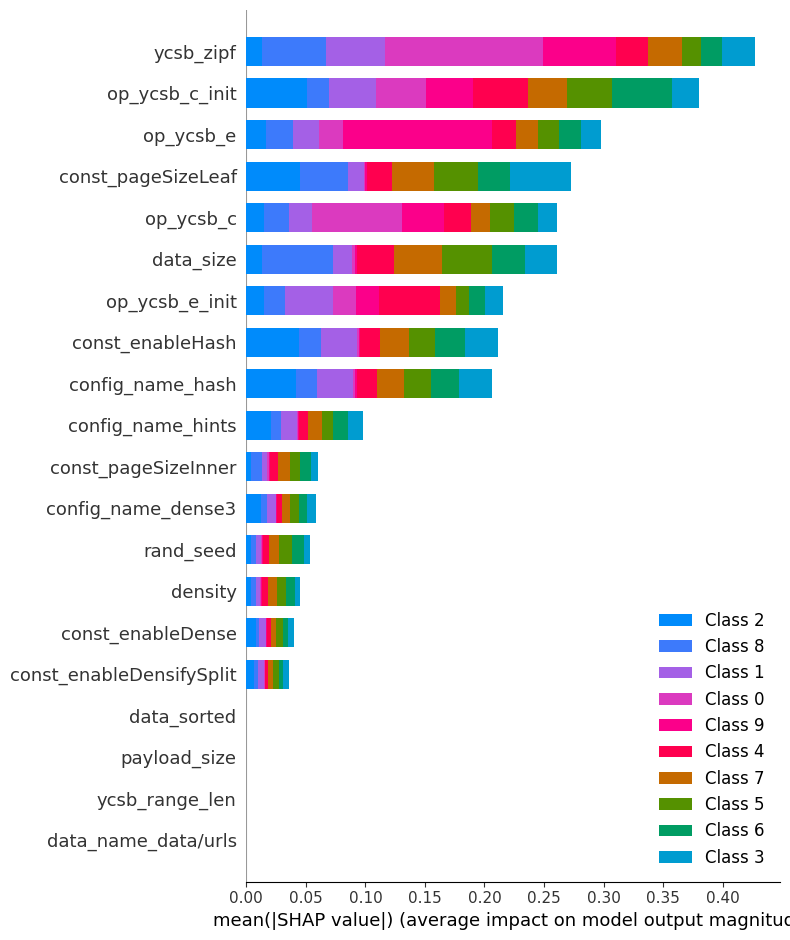

In [6]:
import shap
explainer = shap.Explainer(rf_classifier)

shap_values = explainer.shap_values(input_data)
shap.summary_plot(shap_values, input_data)

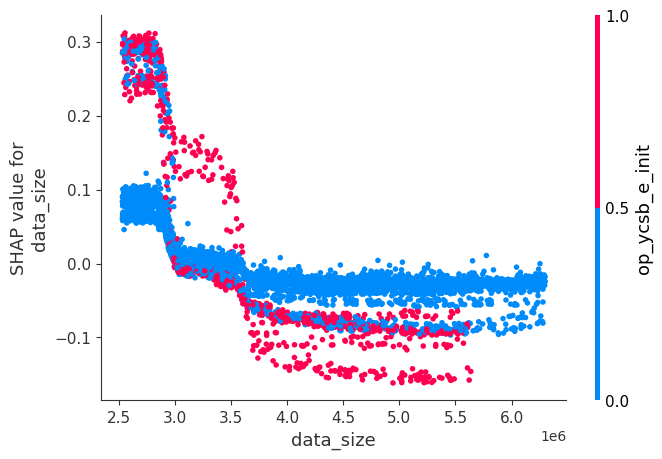

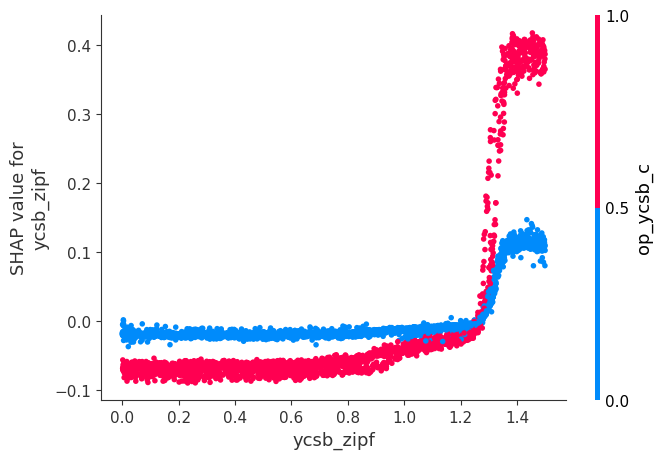

In [27]:
shap.dependence_plot("data_size", shap_values[0], input_data)

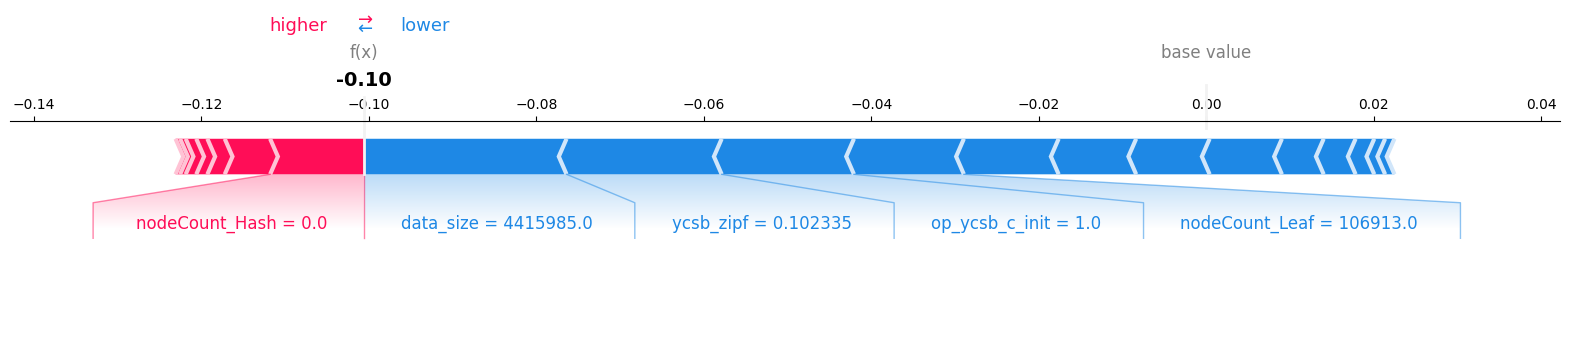

In [38]:
# initialize JS visualization code
import matplotlib
shap.initjs()
shap.force_plot(0, shap_values[0][0], input_data.iloc[0],matplotlib=matplotlib)
#THIS IS USELESS


In [11]:
X_train.replace({False: 0, True: 1}, inplace=True)


In [12]:
from interpret.blackbox import LimeTabular
from interpret import show

lime = LimeTabular(rf_classifier, X_train, random_state=42)
show(lime.explain_local(X_test[:5], y_test[:5]), 0)

Exception: multiclass LIME not supported